# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Notebook created for the guided project [Detecting COVID-19 with Chest X Ray using PyTorch](https://www.coursera.org/projects/covid-19-detection-x-ray) on Coursera

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.8.1+cpu


# Preparing Training and Test Sets

In [2]:
class_names = ['normal', 'viral_pneumonia', 'covid', 'lung_opacity']
root_dir = 'COVID-19_Radiography_Dataset'
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID', 'Lung_Opacity']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names =  ['normal', 'viral_pneumonia', 'covid', 'lung_opacity']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [4]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [115]:
train_dirs = {
    'normal': 'COVID-19_Radiography_Dataset/normal',
    'viral_pneumonia': 'COVID-19_Radiography_Dataset/viral_pneumonia',
    'covid': 'COVID-19_Radiography_Dataset/covid',
    'lung_opacity': 'COVID-19_Radiography_Dataset/lung_opacity'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10162 normal examples
Found 1315 viral_pneumonia examples
Found 3586 covid examples
Found 5982 lung_opacity examples


21045

In [6]:
test_dirs = {
    'normal': 'COVID-19_Radiography_Dataset/test/normal',
    'viral_pneumonia': 'COVID-19_Radiography_Dataset/test/viral_pneumonia',
    'covid': 'COVID-19_Radiography_Dataset/test/covid',
    'lung_opacity': 'COVID-19_Radiography_Dataset/test/lung_opacity'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral_pneumonia examples
Found 30 covid examples
Found 30 lung_opacity examples


In [7]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 3508
Number of test batches 20


# Data Visualization

In [8]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(20,10))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

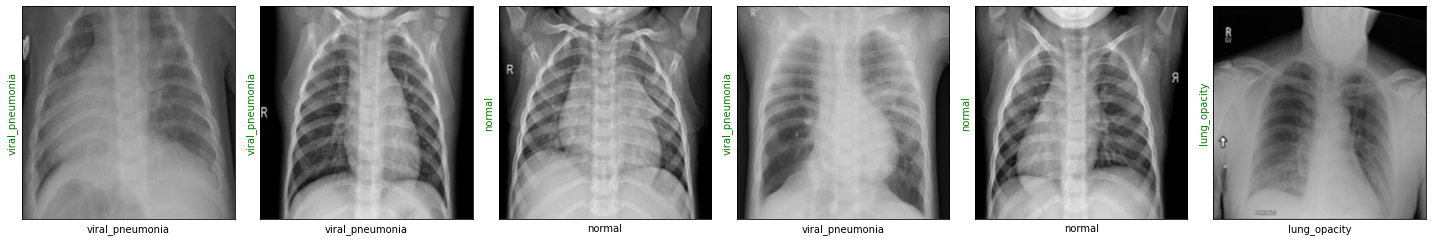

In [9]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

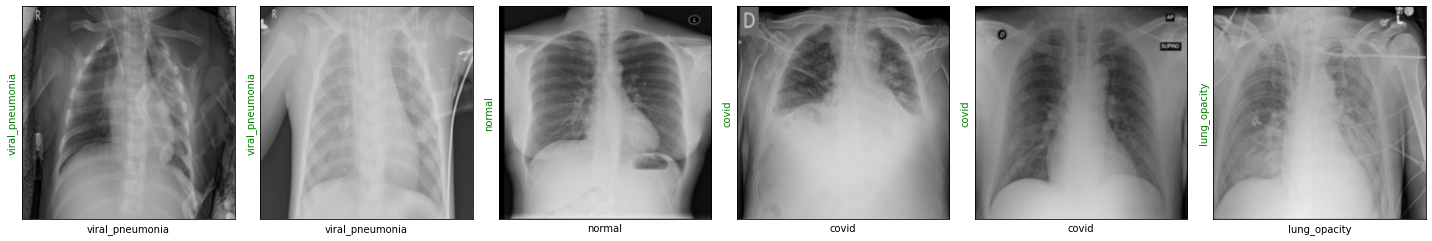

In [10]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [11]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [13]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

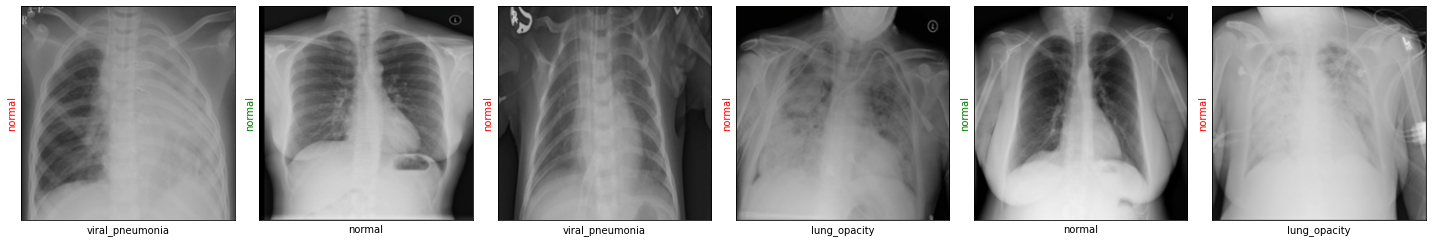

In [14]:
show_preds()

# Training the Model

In [15]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.6849, Accuracy: 0.2583


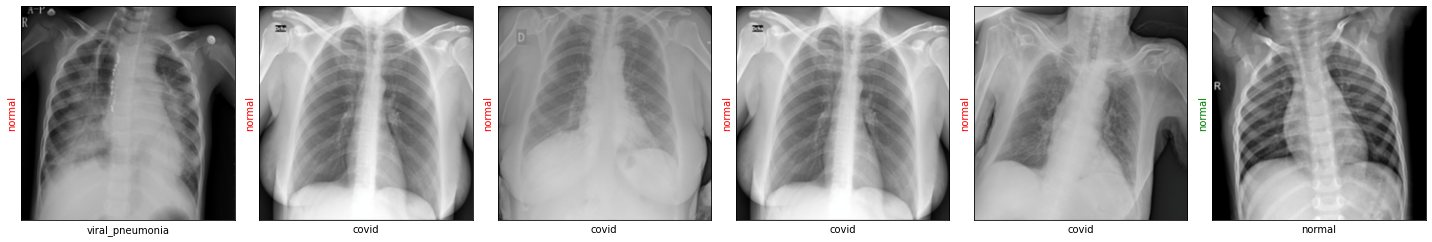

Evaluating at step 20
Validation Loss: 1.2404, Accuracy: 0.4750


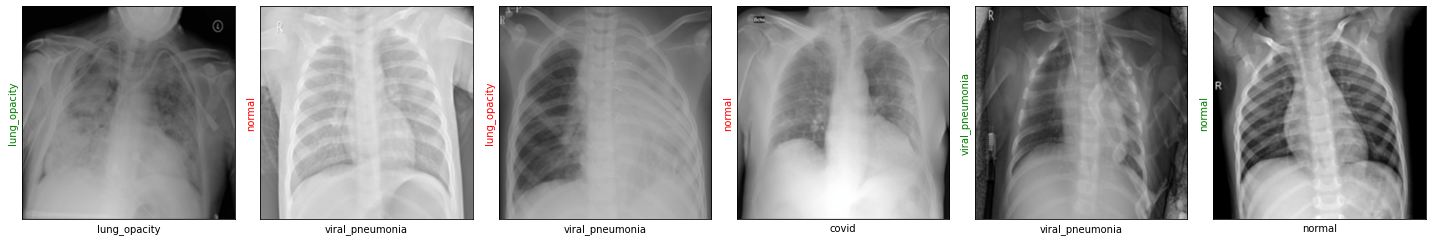

Evaluating at step 40
Validation Loss: 0.9688, Accuracy: 0.6000


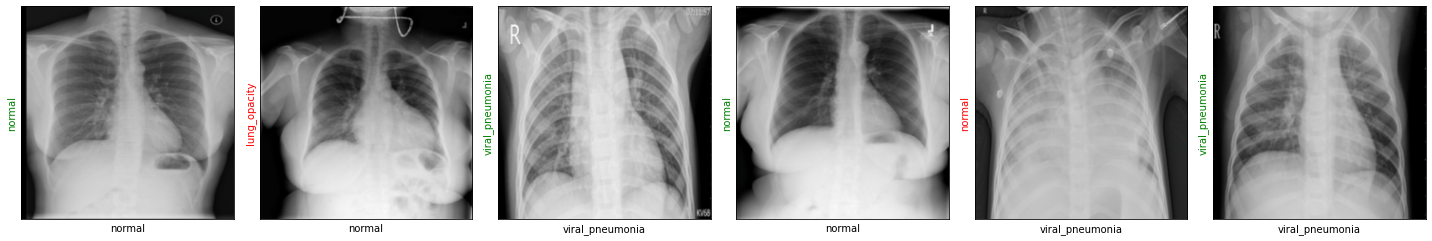

Evaluating at step 60
Validation Loss: 0.7063, Accuracy: 0.7333


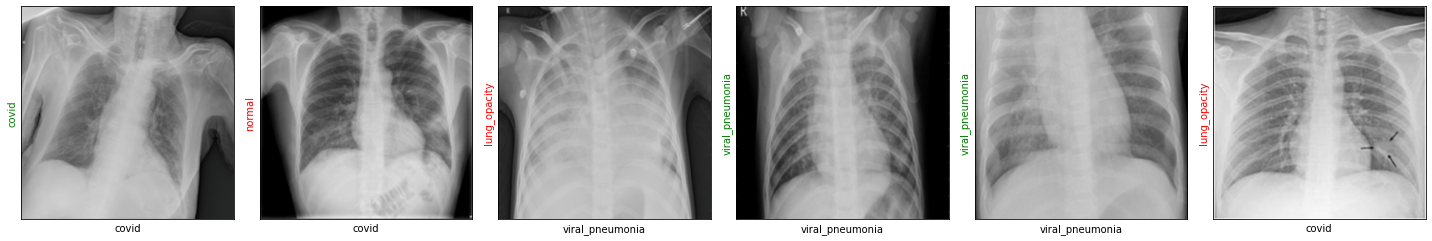

Evaluating at step 80
Validation Loss: 0.6690, Accuracy: 0.7750


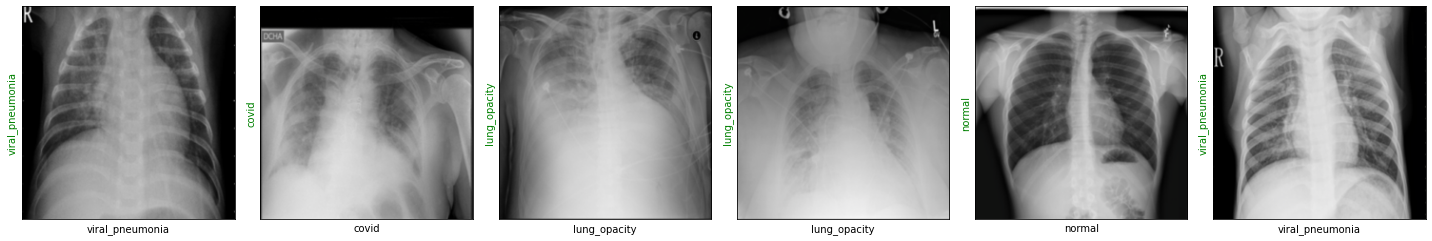

Evaluating at step 100
Validation Loss: 0.5040, Accuracy: 0.8333


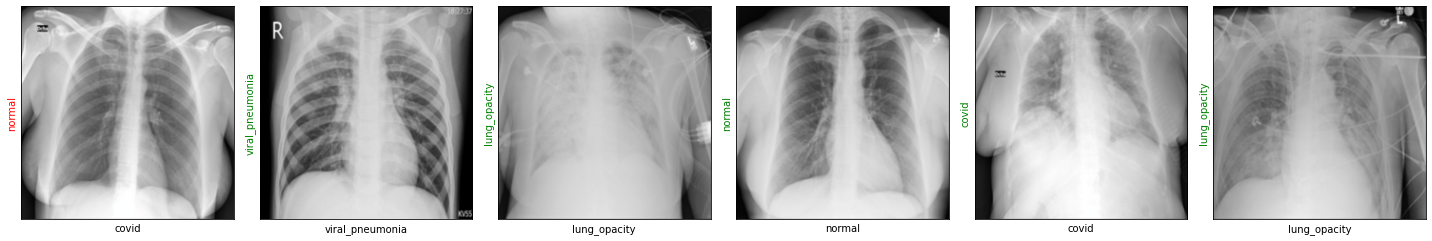

Evaluating at step 120
Validation Loss: 0.4339, Accuracy: 0.8500


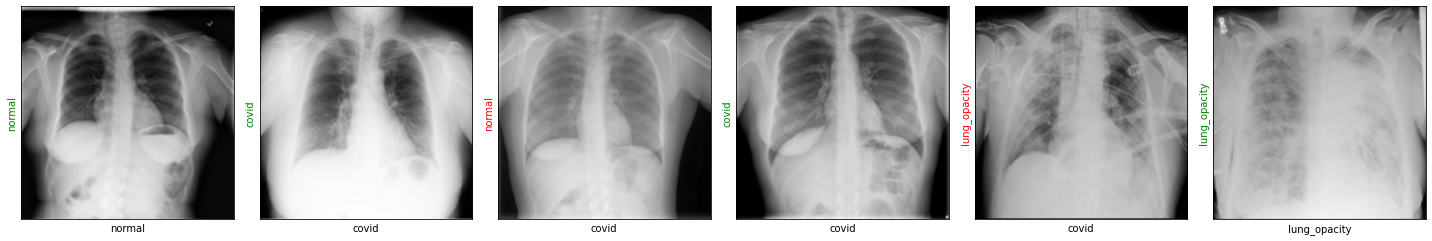

Evaluating at step 140
Validation Loss: 0.4065, Accuracy: 0.8750


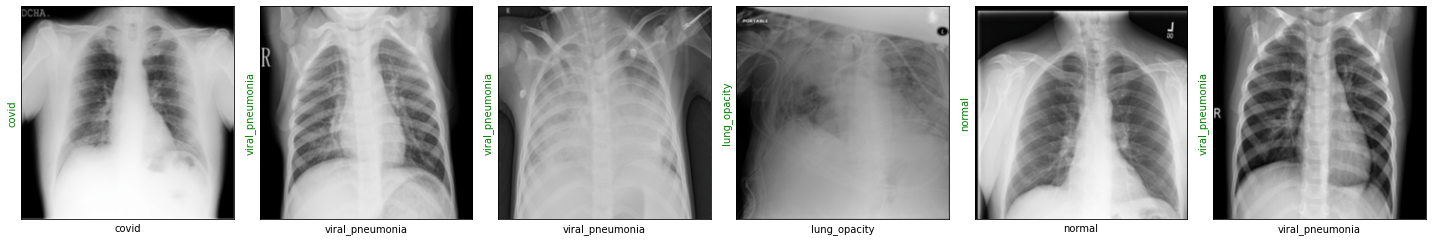

Evaluating at step 160
Validation Loss: 0.4609, Accuracy: 0.8917


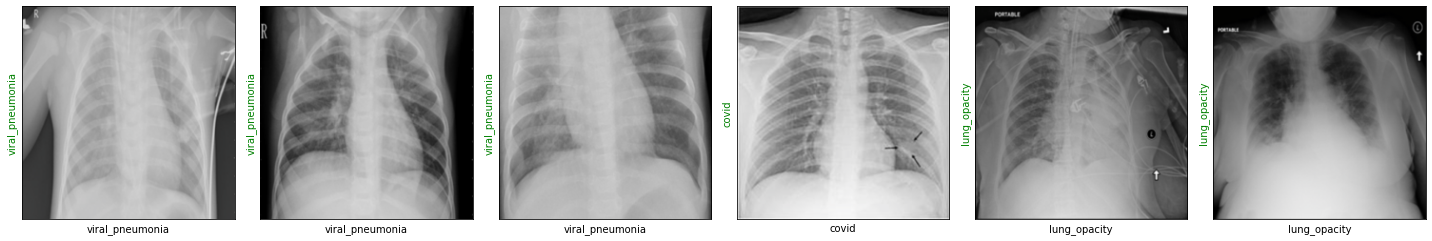

Evaluating at step 180
Validation Loss: 0.4647, Accuracy: 0.8417


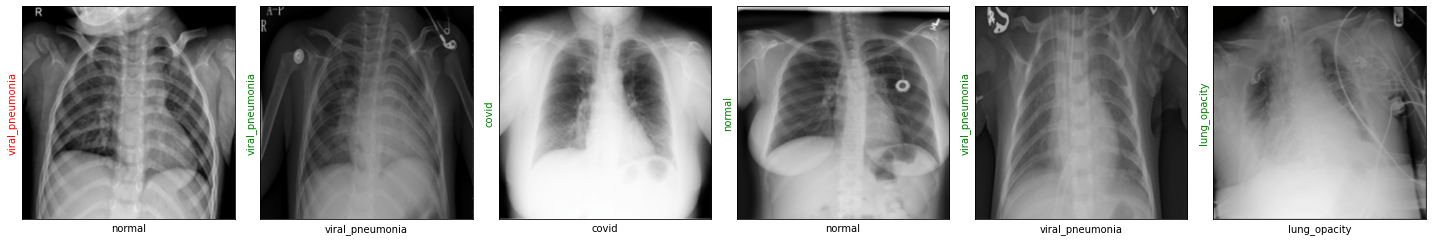

Evaluating at step 200
Validation Loss: 0.3282, Accuracy: 0.8833


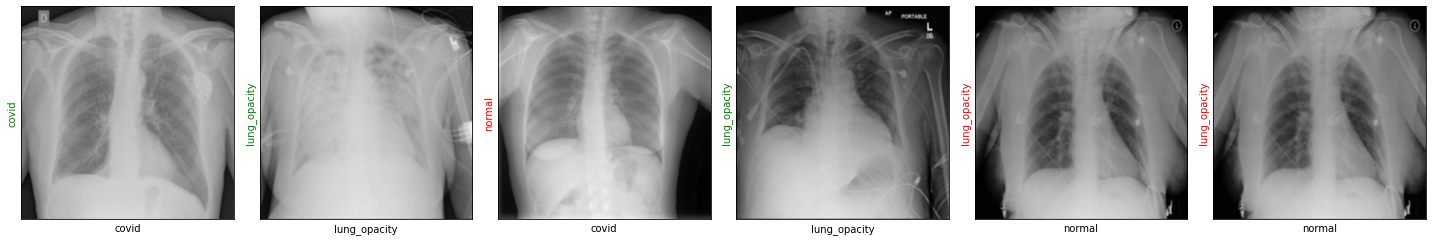

Evaluating at step 220
Validation Loss: 0.3372, Accuracy: 0.8917


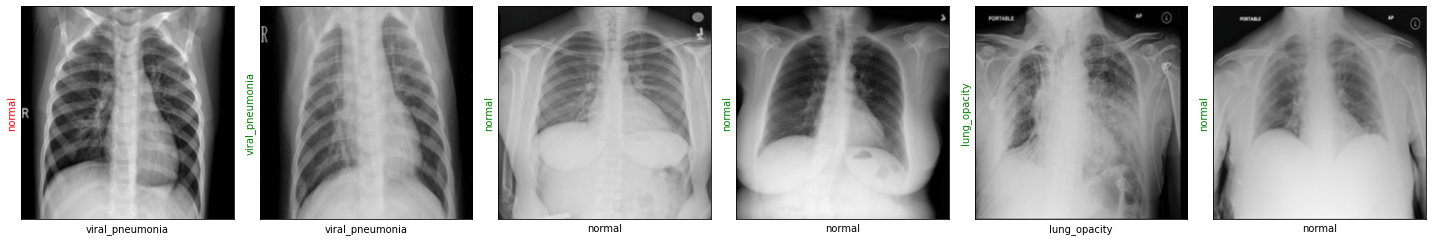

Evaluating at step 240
Validation Loss: 0.2753, Accuracy: 0.9167


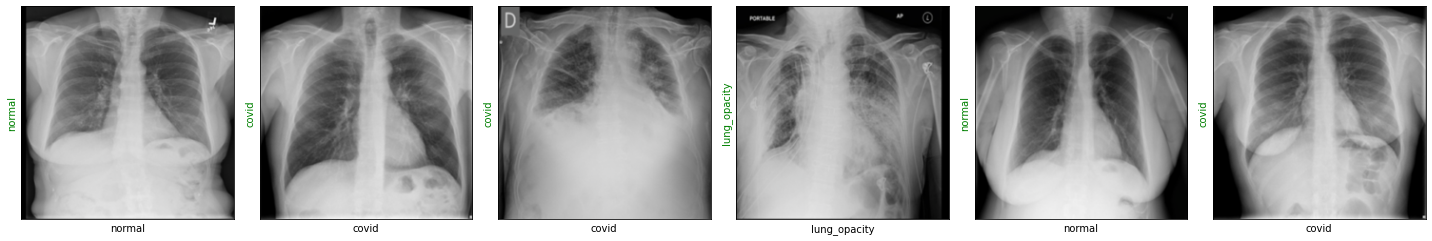

Evaluating at step 260
Validation Loss: 0.3856, Accuracy: 0.8667


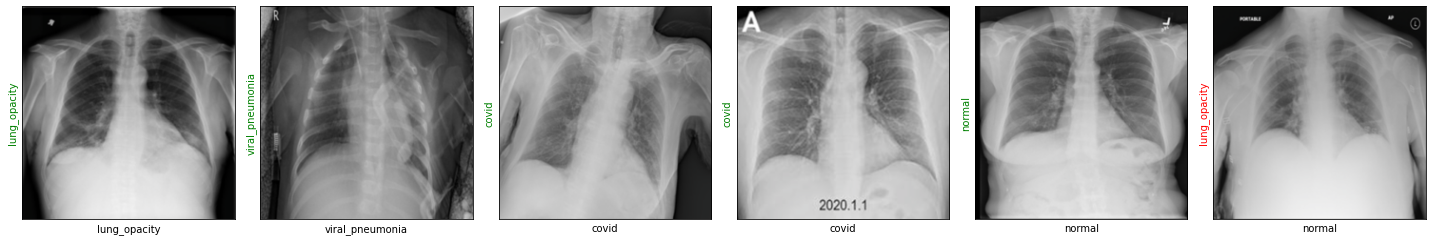

Evaluating at step 280
Validation Loss: 0.3135, Accuracy: 0.9000


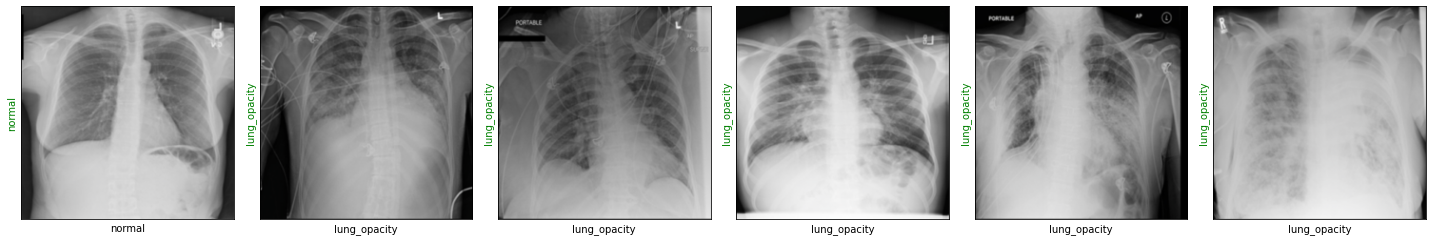

Evaluating at step 300
Validation Loss: 0.2225, Accuracy: 0.9333


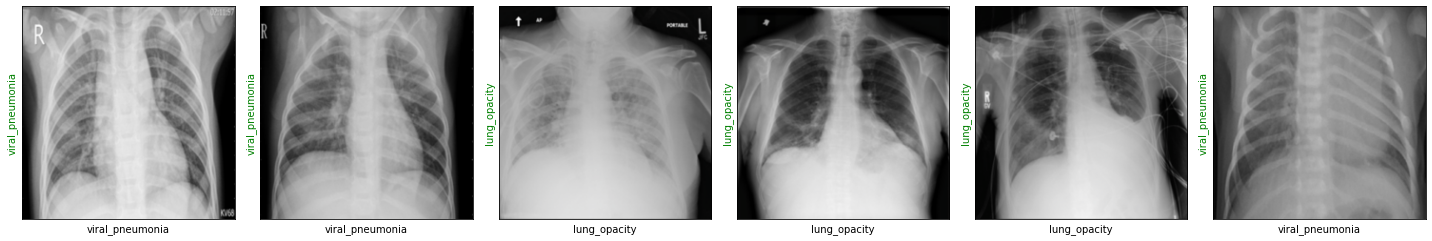

Evaluating at step 320
Validation Loss: 0.3694, Accuracy: 0.8833


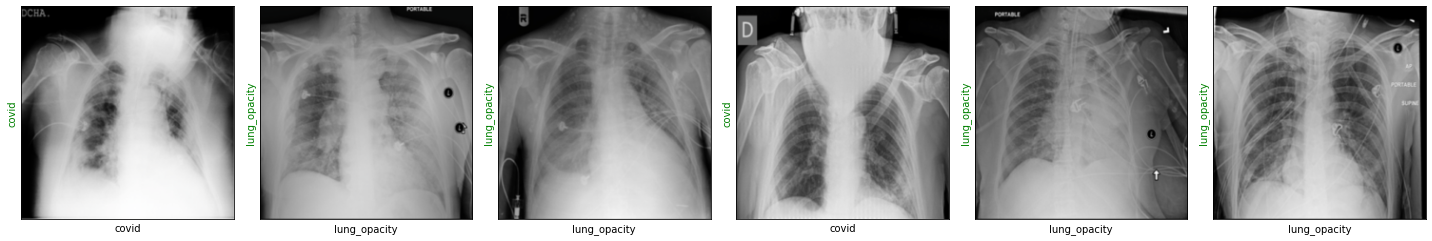

Evaluating at step 340
Validation Loss: 0.2230, Accuracy: 0.9500


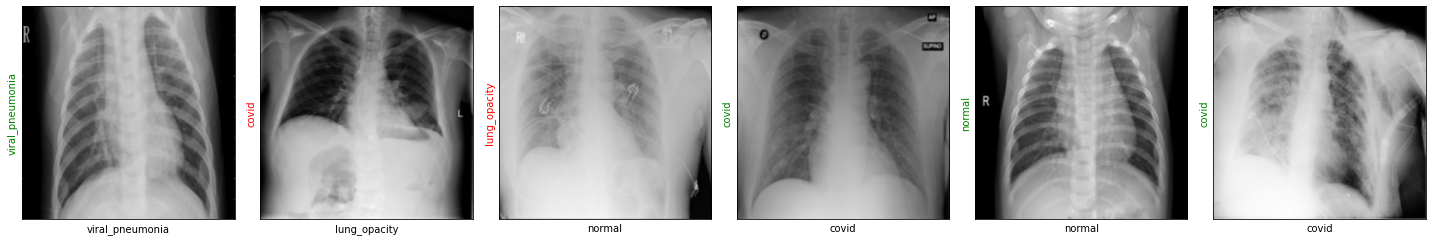

Performance condition satisfied, stopping..
Wall time: 3min 32s


In [16]:
%%time

train(epochs=1)

# Final Results

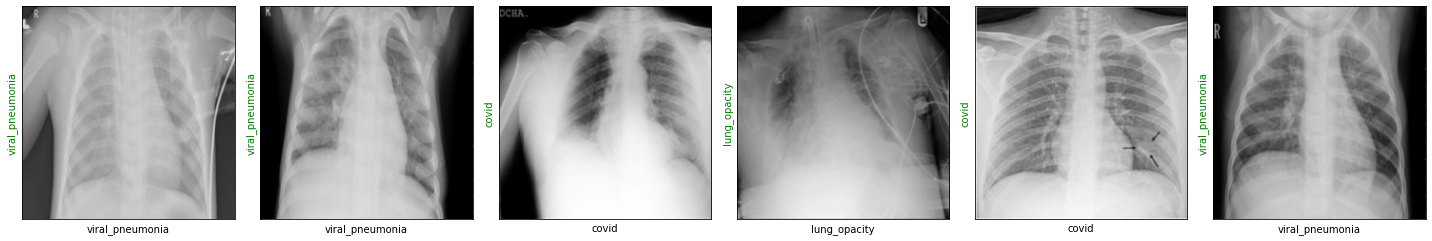

In [17]:
show_preds()

# Metrics
## Data preparation

In [96]:
import torch.nn.functional as F
from torchmetrics import ConfusionMatrix
classes =('Normal','Lung Opacity','Pneumonia','COVID-19')
pred_labels = []
true_labels = []
ps_list = []
running_correct = 0.0
running_total = 0.0

with torch.no_grad():

    for images, labels in dl_test:
            output = resnet18(images)
            ps = F.softmax(output, dim=1)
            output = (torch.max(torch.exp(output), 1)[1]).numpy()
            pred_labels.append(output)
            labels = labels.numpy()
            true_labels.append(labels)
            ps = ps.data.cpu().numpy().squeeze()
            ps_list.append(np.max(ps))
            running_total += len(labels)
            running_correct += (output == labels).sum().item()
    accuracy = running_correct/running_total

target = torch.tensor(true_labels)
preds = torch.tensor(pred_labels)
confmat = ConfusionMatrix(num_classes=4)
mat_tensor = confmat(preds, target)
print(mat_tensor)

tensor([[20.,  0.,  2.,  2.],
        [ 3., 28.,  0.,  0.],
        [ 4.,  0., 28.,  3.],
        [ 1.,  0.,  1., 28.]])


## Accuracy

In [95]:
print("Total Correct Images: {}, Total Test Images: {}".format(int(running_correct), int(running_total)))
print("Test Accuracy: ", accuracy)

Total Correct Images: 105, Total Test Images: 120
Test Accuracy:  0.875


## Confussion Matrix

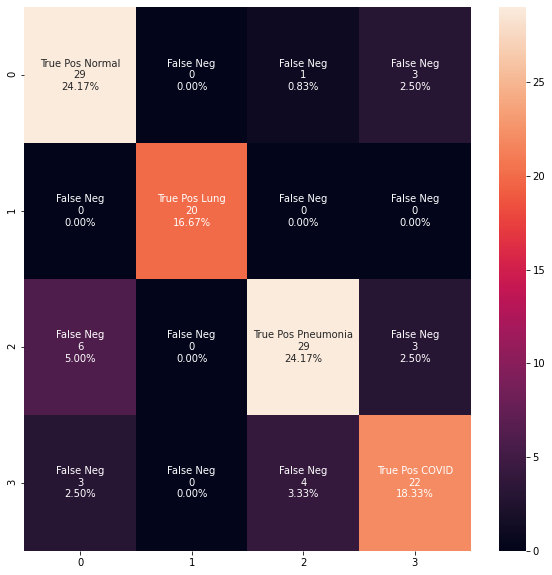

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = mat_tensor.numpy()
group_names = ['True Pos Normal','False Neg','False Neg','False Neg',
               'False Neg','True Pos Lung','False Neg','False Neg',
               'False Neg','False Neg','True Pos Pneumonia','False Neg',
               'False Neg','False Neg','False Neg','True Pos COVID']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_mat.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_mat.flatten()/np.sum(conf_mat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(4,4)
fig, ax = plt.subplots(figsize=(10,10))
ax=sns.heatmap(conf_mat, annot=labels, fmt='',ax=ax)
ax.plot
fig.savefig('confussion.png')

## Precision, Recall, F1 Score & Support

In [38]:
import sklearn.metrics as metrics
print("Classification report :\n%s\n"
      % (metrics.classification_report(true_labels, pred_labels)))

Classification report :
              precision    recall  f1-score   support

           0       0.76      0.88      0.82        33
           1       1.00      1.00      1.00        20
           2       0.85      0.76      0.81        38
           3       0.79      0.76      0.77        29

    accuracy                           0.83       120
   macro avg       0.85      0.85      0.85       120
weighted avg       0.84      0.83      0.83       120




## Area Under the Curve

In [114]:
from torchmetrics import ROC
from torchmetrics import AUROC
from matplotlib import pyplot


roc = ROC(num_classes=4)
auroc = AUROC(num_classes=4)

# define a tensor with probabilities
pred = torch.tensor(ps_list, dtype=torch.float64)
# define a tensor with
target =  torch.tensor(true_labels, dtype=torch.int64)

fpr, tpr, _ = roc(pred, target)

#roc_auc = auroc(pred, target).item()
'''
pyplot.plot([0, 1], [0, 1], linestyle='--', label='')
pyplot.title('ROC curve (area = %0.2f)' % roc_auc)

pyplot.plot(fpr, tpr, marker='.', label='ROC curve')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()
pyplot.show()
'''

c:\users\desktop\appdata\local\programs\python\python37\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\users\desktop\appdata\local\programs\python\python37\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


ValueError: preds and target must have same number of dimensions, or one additional dimension for preds

# Intermediate Layers